In [1]:
# Read a dataset and create a 2d histogram of (consecutive frames) displacement
# Displacements are divided by object's sqrt(A), assuming bigger objects on average move more pixels
# During tracking, 2d histogram is used as a prior, to penalize large displacements for the previous position.

In [2]:
def rect(region):
    x = region[0]
    y = region[1]
    w = region[2]
    h = region[3]
    cx = x+w/2
    cy = y+h/2
    c = np.asarray([cx,cy])
    sz = np.asarray([w,h])
    return c, sz

In [3]:
def poly(region):
    cx = np.mean(region[::2])
    cy = np.mean(region[1::2])
    x1 = np.min(region[::2])
    x2 = np.max(region[::2])
    y1 = np.min(region[1::2])
    y2 = np.max(region[1::2])
    A1 = np.linalg.norm(region[0:2] - region[2:4]) * np.linalg.norm(region[2:4] - region[4:6])
    A2 = (x2 - x1) * (y2 - y1)
    s = np.sqrt(A1/A2)
    w = s * (x2 - x1) + 1
    h = s * (y2 - y1) + 1
    c = np.asarray([cx,cy])
    sz = np.asarray([w,h])
    return c, sz

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm

/home/berti/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
root = '/home/berti/datasets'
dataset = 'validation'
gt_name = 'groundtruth.txt'
out_mat = '../data/displacement_prior.validation.mat'
resp_sz = 33
upsampling = 9
stride = 4
exemplar_sz = 127
dist = []
dist_in_response = np.zeros((resp_sz*upsampling,resp_sz*upsampling))
penalty = np.zeros_like(dist_in_response)
center = np.ceil(resp_sz*upsampling/2)
c = np.asarray([center,center])
for i in xrange(resp_sz*upsampling):
    for j in xrange(resp_sz*upsampling):
        d = np.linalg.norm(np.asarray([i,j]) - c)
        dist_in_response[i,j] = d * stride / (exemplar_sz * upsampling)
        

In [6]:
video_dirs = [d for d in os.listdir(os.path.join(root, dataset)) if os.path.isdir(os.path.join(root, dataset))]

In [7]:
# collect displacement stats from the dataset
for i in tqdm(xrange(len(video_dirs))):
    lines = np.loadtxt(os.path.join(root, dataset,video_dirs[i],gt_name), delimiter=',')
    # check if ground truth is saved as rectangle or polygon
    if len(lines[0])==4:
        map2rect = rect
    else:
        if len(lines[0])==8:
            map2rect = poly
        else:
            raise ValueError('Problem with the GT, it should have 4 or 8 columns.')

    # get rect center <cx,cy> and <w,h>                
    [c0,sz0] = map2rect(lines[0])

    for j in range(1,len(lines)):        
        [c1,sz1] = map2rect(lines[j])
        # compute dist with next frame and divide by sqrt of avg area
        d = np.linalg.norm(c1-c0) / np.sqrt(0.5*np.prod(sz0) + 0.5*np.prod(sz1))
        dist.append(d)
        c0 = c1
        sz0 = sz1

100%|██████████| 129/129 [00:01<00:00, 67.69it/s]


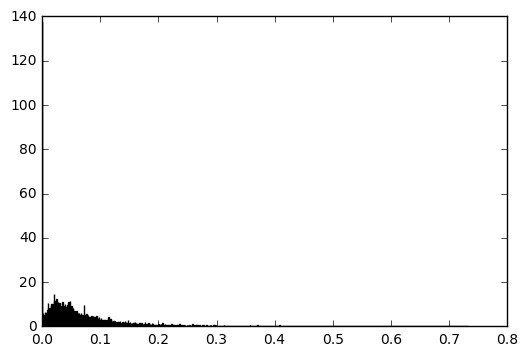

In [36]:
bins = np.linspace(0, np.max(dist_in_response), 1000)
# bins = np.insert(bins, 1, 1e-3) # add an extra bin for 0 distance entries
dist_limited = [d for d in dist if d<=np.max(dist_in_response)]
n = plt.hist(dist_limited, bins=bins, normed=1)
# plt.xscale('log')
plt.show()


/home/berti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


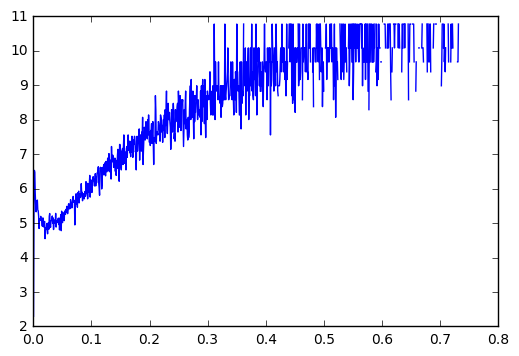

In [37]:
y = n[0]
y = y / (np.sum(y))
x = n[1]
# densities_n = densities/np.sum(densities)
x = 0.5*(x[:-1]+x[1:])
plt.plot(x, -np.log(y))
plt.show()

In [20]:
for i in xrange(resp_sz*upsampling):
    for j in xrange(resp_sz*upsampling):
        # find the bin with the dist_in_response value and save in penalty
        idx = np.where(bins>=dist_in_response[i,j])[0][0]-1
        penalty[i,j] = densities[idx]
        
# penalty = penalty/np.sum(penalty)

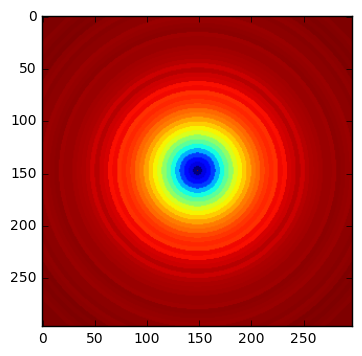

In [17]:
plt.imshow(penalty)
plt.show()

In [12]:
scipy.io.savemat(out_mat, mdict={'penalty':penalty})